# City of Philadelphia Licenses and Inspections Appeals <a id='top'></a>

The dataset contains decisions of Philadelphia Licenses and Inspections Appeal Board. The dataset contains 28869 records and 37 columns.

Several columns such as Appeal Grounds, Related Permits and Proviso are in Natural Language format. 

Source: https://www.opendataphilly.org/dataset/license-and-inspections-appeals/resource/b721ad52-9e27-46d2-b494-6bf0ef1c7603?inner_span=True

### I would like to research the relationship of the board decision stored in the column 'decision' and other values in the dataset such as Appeal Grounds(NL), Related Permits(NL), Proviso(NL) and well as property address(geospatial).


## Table of Content

[Load and review the data](#Load-and-review-the-data)  
[Loading necessary packages](#Loading-necessary-packages)  
[Clear out Null values](#Clear-out-Null-values)  
[Clean Zip column](#Clean-Zip-column)  
[Remove /PROV value from decision column and store it as a flag in a separate field](#Remove-/PROV-value-from-decision-column-and-store-it-as-a-flag-in-a-separate-field)  
[Translate appeal decision into new feature and reduce the number of outcomes](#Translate-appeal-decision-into-new-feature-and-reduce-the-number-of-outcomes)  
[Dataset Centroids and distances from them](#Dataset-Centroids-and-distances-from-them)  
[Distances from Landmarks](#Distances-from-Landmarks)  
[Scatter Plot Map](#Scatter-Plot-Map)  
[myMetrics Function for model testing](#myMetrics-Function-for-model-testing)
[Pre-processing and Test/Train Split](#Pre-processing-and-Test/Train-Split)

### Loading necessary packages  <a id='Loading-necessary-packages'></a>

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics #metrics module

hypertable=[]

### Load and review the data <a id='Load-and-review-the-data'></a> 
[(back to the top)](#top)

In [2]:
#Database URL
url = 'https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+appeals&filename=appeals&format=csv&skipfields=cartodb_id'
#Initial Dataset load
df = pd.read_csv(url, low_memory=False)

In [3]:
#Sample data
df.head()

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
0,0101000020E610000037BAFB2B1DC352C03A158AB3C90A...,0101000020110F000083B7668792DE5FC1D7531E50DD9B...,8,716319.0,8940 KREWSTOWN RD,NaN,118,19115-4517,888630077.0,646106,...,2010-05-04 13:15:00,MOOT,NaN,COMPLIED,2010-05-04 00:00:00,HANSEN,2.724252e+06,285119.162422,40.084280,-75.048656
1,0101000020E61000003690253716C852C06DEBA50163FD...,0101000020110F00008ED1ECEB04E75FC16710A3FAFF8C...,9,628798.0,2300 E YORK ST,NaN,NaN,19125-2120,313145500.0,363094,...,2009-10-28 17:00:00,GRANTED,NaN,NaN,2009-10-28 00:00:00,HANSEN,2.703654e+06,246341.440497,39.979584,-75.126356
2,0101000020E61000003C08EF26A0CB52C03BDF48F08D06...,0101000020110F0000E86105BF07ED5FC1EBBBD9912A97...,10,531963.0,128 E SHARPNACK ST,NaN,NaN,19119-2237,221108000.0,313082,...,2009-12-29 13:15:00,MOOT,NaN,COMPLIED,2009-12-30 00:00:00,HANSEN,2.687406e+06,271965.871360,40.051207,-75.181650
3,0101000020E61000000E3A31E95AC552C0FDEF06071902...,0101000020110F000085E81E1561E25FC16F05D2083992...,11,297984.0,4671 FRANKFORD AVE,NaN,NaN,19124-5827,871529760.0,565329,...,2009-10-06 09:30:00,GRANTED,NaN,NaN,2009-10-06 00:00:00,HANSEN,2.715205e+06,260100.891162,40.016389,-75.083674
4,0101000020E6100000926D2397A0CE52C05ED5D7D893FB...,0101000020110F0000A996150421F25FC15C0150B0FE8A...,12,589254.0,5421 VINE ST,NaN,NaN,19139-2041,41034400.0,511115,...,2009-12-29 13:15:00,WITHDRAWN,NaN,NaN,2009-10-21 00:00:00,HANSEN,2.675173e+06,240360.419544,39.965449,-75.228552


In [4]:
#Number of rows and features
print("df.shape", df.shape)

df.shape (29599, 37)


In [5]:
#Column Names
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng'],
      dtype='object')

In [6]:
#General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29599 entries, 0 to 29598
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              28985 non-null  object 
 1   the_geom_webmercator  28985 non-null  object 
 2   objectid              29599 non-null  int64  
 3   addressobjectid       29024 non-null  float64
 4   address               29013 non-null  object 
 5   unit_type             98 non-null     object 
 6   unit_num              551 non-null    object 
 7   zip                   29013 non-null  object 
 8   opa_account_num       27765 non-null  float64
 9   parcel_id_num         28343 non-null  object 
 10  censustract           28985 non-null  float64
 11  opa_owner             28439 non-null  object 
 12  primaryappellant      29599 non-null  object 
 13  appellanttype         29029 non-null  object 
 14  internaljobid         27715 non-null  float64
 15  appealnumber       

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

### Clear out Null values <a id='Clear-out-Null-values'></a>
[(back to the top)](#top)

I am dropping records with Null value in Decision column. They represent less than 10% of the data. With the multitude of unique values in that column I can't decide what value I can replace it with.

In [7]:
df = df[~df['decision'].isna()]
df[df['systemofrecord'].isna()]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [8]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

In [9]:
df[df['lat'].isna()].shape[0]

17

I'm dropping these as well.

In [10]:
df = df[~df['lat'].isna()]

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

### Clean Zip column
[(back to the top)](#top)

In [11]:
pd.concat([df['zip'].astype('str').str.slice(0,5), df['zip'].astype('str').str.slice(6,10)],axis = 1)

,zip,zip
0,19115,4517
1,19125,2120
2,19119,2237
3,19124,5827
4,19139,2041
...,...,...
29558,19137,1640
29559,19154,1899
29560,19146,3015
29562,19145,4112


In [12]:
#(df['zip'].astype('str').str.slice(0,5) + df['zip'].astype('str').str.slice(6,10)).astype('int')
#df['zip'].astype('str').str.slice(0,5).astype('int')

In [13]:
#Percent of unique values per values per column
df.nunique()/df.shape[0]

the_geom                0.802057
the_geom_webmercator    0.802057
objectid                1.000000
addressobjectid         0.815016
address                 0.805176
unit_type               0.000149
unit_num                0.004344
zip                     0.487190
opa_account_num         0.774915
parcel_id_num           0.772390
censustract             0.014184
opa_owner               0.706334
primaryappellant        0.458005
appellanttype           0.000297
internaljobid           0.979912
appealnumber            1.000000
acceleratedappeal       0.000074
createddate             0.998589
completeddate           0.448945
relatedpermit           0.981323
relatedcasefile         0.000223
appealstatus            0.000297
appealtype              0.000371
agendadescription       0.000037
applicationtype         0.000260
meetingnumber           0.020088
appealgrounds           0.922843
scheduleddate           0.174588
decision                0.001188
meetingresult           0.000186
proviso   

In [14]:
df.dtypes

the_geom                 object
the_geom_webmercator     object
objectid                  int64
addressobjectid         float64
address                  object
unit_type                object
unit_num                 object
zip                      object
opa_account_num         float64
parcel_id_num            object
censustract             float64
opa_owner                object
primaryappellant         object
appellanttype            object
internaljobid           float64
appealnumber             object
acceleratedappeal        object
createddate              object
completeddate            object
relatedpermit            object
relatedcasefile          object
appealstatus             object
appealtype               object
agendadescription        object
applicationtype          object
meetingnumber            object
appealgrounds            object
scheduleddate            object
decision                 object
meetingresult            object
proviso                  object
decision

In [15]:
df['createddate'] = pd.to_datetime(df['createddate'])

In [16]:
df['completeddate'] = pd.to_datetime(df['completeddate'])
df['scheduleddate'] = pd.to_datetime(df['scheduleddate'])
df['decisiondate'] = pd.to_datetime(df['decisiondate'])

In [17]:
#Top examples of "appealgrounds"
df['appealgrounds'].value_counts().head(10)

PERMIT FOR TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                       111
PERMIT FOR A TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                      65
WE ARE APPEALING THE ISSUANCE OF BUILDING PERMIT #765070 FOR HEALTH AND ENVIRONMENTAL CONCERNS.     63
PERMIT FOR THREE (3) FAMILY DWELLING (MULTI-FAMILY DWELLING) IN AN EXISTING STRUCTURE.              56
PERMIT FOR A TWO(2) FAMILY DWELLING.                                                                55
PERMIT FOR A THREE(3) FAMILY DWELLING.                                                              51
PERMIT FOR A TWO(2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                       37
PERMIT FOR A TWO (2) FAMILY DWELLING.                                                               36
PERMIT FOR A TWO FAMILY DWELLING.                                                                   35
PERMIT FOR TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE              

In [18]:
#Top examples of "relatedpermit"
df['relatedpermit'].value_counts().head(10)

Description of Project:  SM/LRG FOOD ESTAB\n  APPEAL TYPES==> \nAPPEAL TYPE: LI-REFGRNT  \n\n  BOARD DECISIONS==> \nDECISION: CONTINUED  DECDATE: 16-OCT-18  PROVISO:   \n\n  COURT APPEALS==> \n                                                                                                                                                                                                  29
Description of Project:  BUILDING PERMIT #765070\n  APPEAL TYPES==> \nAPPEAL TYPE: AGAINSTL&I  \n\n  BOARD DECISIONS==> \nDECISION: AFFIRMED  DECDATE: 28-JUL-17  PROVISO:   \n\n  COURT APPEALS==> \n                                                                                                                                                                                             28
Description of Project:  PWD\n  APPEAL TYPES==> \nAPPEAL TYPE: WATER  \n\n  BOARD DECISIONS==> \n\n  COURT APPEALS==> \n                                                                                                    

In [19]:
#Top value of "proviso"
df['proviso'].value_counts().head(10)

COMPLIED                                                          1751
FOR WANT OF APPEARANCE                                             737
*****CASE WITHDRAWN.*****                                          402
*****CASE DISMISSED.*****                                          163
*****CASE DISMISSED - PUT INTO ENFORCEMENT.*****                   109
60 DAY STAY OF ENFORCEMENT                                         101
90 DAY STAY OF ENFORCEMENT                                          85
30 DAY STAY OF ENFORCEMENT                                          58
WITHOUT PREJUDICE;  CITY HAS THE RIGHT TO RE-ISSUE VIOLATIONS.      54
120 DAY STAY OF ENFORCEMENT                                         53
Name: proviso, dtype: int64

In [20]:
#Breakdown by decision
df['decision'].value_counts()

GRANTED         8436
GRANTED/PROV    6260
WITHDRAWN       2420
MOOT            2283
AFFIRMED        1956
DENIED          1796
APPROVED        1554
DISMISSED        936
Granted          429
SUSTAINED        255
CONTINUED        224
Withdrawn         73
DENIED/PROV       69
ADMIN/REVIEW      63
DISMI/ENFORC      42
REMAND            38
Denied            25
HELD              17
NEWHEARNOT        12
HELD/INFO          9
BOARDAKNOWL        7
Approved           7
Refused            4
REFUSED            3
LATE-APPRVD        3
REVISED            2
Dismissed          2
LATE-DENIED        2
NEWHEARYES         2
RESCHEDULE         1
ISSUED             1
Revised            1
Name: decision, dtype: int64

In [21]:
# Save the values
df['decisionsv']=df['decision']

In [22]:
df[(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == True)][['decision', 'proviso']]

,decision,proviso
3598,DENIED/PROV,NaN
25742,GRANTED/PROV,NaN


Even though there are only two records, it appears that /PROV in the 'decision' field doesn't mean that there is value in the field 'proviso'

In [23]:
df[~(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == False)][['decision', 'proviso']]

,decision,proviso
0,MOOT,COMPLIED
2,MOOT,COMPLIED
9,AFFIRMED,CITY WILL STAY ENFORCEMENT FOR 60 DAYS TO SECU...
21,AFFIRMED,CITY WILL STAY ENFORCEMENT ACTION FOR 90 DAYS.
22,MOOT,COMPLIED
...,...,...
29482,Granted,"Proviso: Revised plans, 1 page, approved today."
29485,MOOT,COMPLIED
29508,AFFIRMED,FOR WANT OF APPEARANCE
29527,Granted,"With Proviso: Revised plans, 2 pgs., approved ..."


not having /PROV in 'decision' field doesn't mean no value in 'provision'

### Remove /PROV value from decision column and store it as a flag in a separate field
[(back to the top)](#top)

In [24]:
# Add new field prvFlag to store "/PROV" from decision
df['provFlag'] = (df['decision'].str.contains('/PROV') == True).astype('int')

In [25]:
df[df['decision'].str.contains('/PROV')]['decision'].str.len().unique()

array([12, 11], dtype=int64)

In [26]:
def stripProviso (decision):
    if '/PROV' in decision:
        strLength = len(decision)
        return decision[0: strLength-5]
    else:
        return decision

In [27]:
df['decision'] = df['decision'].apply(stripProviso)

In [28]:
df[['decision','decisionsv','provFlag']]

,decision,decisionsv,provFlag
0,MOOT,MOOT,0
1,GRANTED,GRANTED,0
2,MOOT,MOOT,0
3,GRANTED,GRANTED,0
4,WITHDRAWN,WITHDRAWN,0
...,...,...,...
29558,GRANTED,GRANTED,0
29559,Refused,Refused,0
29560,Approved,Approved,0
29562,Granted,Granted,0


### Change case for all decisions to lower case

In [29]:
df['decision'] = df['decision'].str.lower()

### Combine dismissed and withdrawn as dismissed

In [30]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismi/enforc', 'dismissed']

In [31]:
def dismissed (decision):
    if 'dismi' in decision or decision == 'withdrawn':
        return 'dismissed'
    else:
        return decision

In [32]:
df['decision'] = df['decision'].apply(dismissed)

In [33]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismissed']

In [34]:
sorted(df['decision'].unique())

['admin/review',
 'affirmed',
 'approved',
 'boardaknowl',
 'continued',
 'denied',
 'dismissed',
 'granted',
 'held',
 'held/info',
 'issued',
 'late-apprvd',
 'late-denied',
 'moot',
 'newhearnot',
 'newhearyes',
 'refused',
 'remand',
 'reschedule',
 'revised',
 'sustained']

In [35]:
df['decision'].value_counts()

granted         15125
dismissed        3473
moot             2283
affirmed         1956
denied           1890
approved         1561
sustained         255
continued         224
admin/review       63
remand             38
held               17
newhearnot         12
held/info           9
refused             7
boardaknowl         7
revised             3
late-apprvd         3
newhearyes          2
late-denied         2
issued              1
reschedule          1
Name: decision, dtype: int64

In [36]:
df[(df['decision'] == 'complete')]['meetingresult'].value_counts()

Series([], Name: meetingresult, dtype: int64)

In [37]:
df[(df['decision'] == 'continued')]['meetingresult'].value_counts()

Series([], Name: meetingresult, dtype: int64)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
### Translate appeal decision into new feature and reduce the number of outcomes
[(back to the top)](#top)

In [38]:
def translateComplete(meetingresult):
    switcher = {
        'Granted':'approved',
        'Denied':'denied',
        'Withdrawn':'other',
        'Dismissed':'denied',
        'Approved':'approved',
        'Refused':'denied'                
        }
    return switcher.get(meetingresult, 'other') 

#def CompleteDecision(decision, meetingresult):
def CompleteDecision(arg):
    if arg[0] == 'complete':
        return translateComplete(arg[1])
    else:
        return arg[0]

    
def funcNewDecision(decision): 
    switcher = {
        'admin/review': 'other',
        'affirmed':'denied',
        'approved':'approved',
        'boardaknowl':'other',
        'cancelled':'other',
        'complete':'complete',
        'continued':'other',
        'denied':'denied',
        'dismissed':'other',
        'granted':'approved',
        'held':'denied',
        'held/info':'denied',
        'issued':'other',
        'late-apprvd':'other',
        'late-denied':'other',
        'moot':'other',
        'newhearnot':'other',
        'newhearyes':'other',
        'refused':'denied',
        'remand':'other',
        'reschedule':'other',
        'rescheduled':'other',
        'revised':'other',
        'sustained':'denied'
        } 
    return switcher.get(decision, 'other') 

df['decision'].apply(funcNewDecision).value_counts()

df[df['decision'] == 'complete']['meetingresult'].apply(translateComplete).value_counts()

df[['decision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()

#df['newDecision'] = df[df['decision'] == 'complete'][['newDecision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()


granted         15125
dismissed        3473
moot             2283
affirmed         1956
denied           1890
approved         1561
sustained         255
continued         224
admin/review       63
remand             38
held               17
newhearnot         12
held/info           9
refused             7
boardaknowl         7
revised             3
late-apprvd         3
newhearyes          2
late-denied         2
issued              1
reschedule          1
dtype: int64

In [39]:
df['newDecision'] = df['decision'].apply(funcNewDecision)
df['newDecision'] = df[['newDecision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision)
df['newDecision'].value_counts()

approved    16686
other        6112
denied       4134
Name: newDecision, dtype: int64

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

In [40]:
pd.set_option('display.max_colwidth', None)
df[df['decision'] == 'held/info'].head(5)

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision
4064,0101000020E6100000CCF7447DB4CD52C0B3F0B9DC37F84340,0101000020110F0000B4D87CF98FF05FC10B2C36E745875241,3697,622915.0,5000-40 WOODLAND AVE,NaN,NaN,19143-5100,773182100.0,145910,...,FOR TAX CERT,2011-04-13,HANSEN,2.679485e+06,230919.547094,39.939205,-75.214141,HELD/INFO,0,denied
7123,0101000020E61000000BDC3CA74DCA52C06FEFAEB9B0034440,0101000020110F000051F299C5C8EA5FC1D48F1C31FD935241,6800,398758.0,34 E LOGAN ST,NaN,NaN,19144-3017,121004500.0,343791,...,VOTE IN 2 WEEKS; APPLICANT & COMMUNITY TO MEET RE: PARKING ISSUES; LETTER TO ZBA 2 WEEKS,2008-08-19,HANSEN,2.693426e+06,263987.075341,40.028831,-75.160990,HELD/INFO,0,denied
9853,0101000020E610000009FB5E34FECA52C0CB57E0F6A8F44340,0101000020110F0000F7F87AA9F4EB5FC1A043E81B55835241,9871,51909.0,3101 S BROAD ST,NaN,NaN,19148-5239,395370400.0,183090,...,VOTE 3/18/08; HOLD FOR 5-PAGE SUMMARY FROM EACH SIDE.,2008-03-20,HANSEN,2.691658e+06,221141.422866,39.911406,-75.171765,HELD/INFO,0,denied
19591,0101000020E6100000DDCDED235ECB52C058A5DB6590F74340,0101000020110F000000615C9E97EC5FC1D3290B698C865241,19926,671302.0,1400 S 20TH ST,NaN,NaN,19146-4507,871549280.0,25999,...,HELD 60 DAYS PENDING REVISED REFUSAL FROM L&I & RCO MEETING/COUNCIL PERSON,2020-01-22,HANSEN,2.689776e+06,229354.773235,39.934094,-75.177621,HELD/INFO,0,denied
20662,0101000020E6100000ACCC8E97F4C952C02A4FBFD171004440,0101000020110F000026FB0C7E31EA5FC143D33AC363905241,20286,660781.0,3259 N 16TH ST,NaN,NaN,19140-4910,112194800.0,250252,...,letter from RCO and C/W,2019-02-06,HANSEN,2.695219e+06,254798.523686,40.003473,-75.155554,HELD/INFO,0,denied


In [41]:
df[df['proviso'].isnull() == True]
df[(df['decision'].str.contains("PROV") == True) & (df['decision'] != 'approved')  & (df['proviso'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision


In [42]:
df[df['meetingresult'].isnull() == False]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision
49,0101000020E610000012821833D5CA52C07F2461F5DAFC4340,0101000020110F0000B64DCD02AFEB5FC12485D831698C5241,53,127982554.0,2000 SEYBERT ST,NaN,NaN,19121-4817,291053500.0,37094,...,NaN,2020-09-10 19:28:54,ECLIPSE,2.691679e+06,244475.379312,39.975432,-75.169263,Granted,0,approved
144,0101000020E61000006497CCB975CF52C01CAA81C33CF94340,0101000020110F00009E16410C8BF35FC1461F7AEB66885241,517,15329544.0,917 S 59TH ST,NaN,NaN,19143-3005,871507100.0,263746,...,NaN,2020-10-14 15:46:02,ECLIPSE,2.671717e+06,233599.263675,39.947167,-75.241560,Withdrawn,0,other
182,0101000020E6100000C059FE156BCE52C0825CB53C96054440,0101000020110F000074021B22C6F15FC1D9F1A2C117965241,209,15545853.0,531 LIVEZEY ST,NaN,NaN,19128-2419,213345552.0,338238,...,NaN,2020-11-30 14:40:49,ECLIPSE,2.675274e+06,268861.081608,40.043647,-75.225286,Granted,0,approved
187,0101000020E6100000CD419D8477CB52C0A9B31D776BF74340,0101000020110F00006F7BA2B9C2EC5FC1ADADEB8063865241,518,15386402.0,2038 DICKINSON ST,NaN,NaN,19146-4544,363052700.0,444970,...,"Proviso: Revised plans; 3 pages, approved today.",2020-11-17 13:44:25,ECLIPSE,2.689354e+06,228931.720631,39.932967,-75.179170,Granted,0,approved
248,0101000020E61000004D7BC1E443CA52C0663B07BF14FC4340,0101000020110F000075A8AD31B8EA5FC12ED763878D8B5241,238,15453232.0,842 N BROAD ST,NaN,NaN,19130-2234,882885597.0,464788,...,NaN,2020-10-09 11:02:37,ECLIPSE,2.694228e+06,242345.549053,39.969383,-75.160394,Granted,0,approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29541,0101000020E6100000AA4F8605FBC752C0D28907B674FE4340,0101000020110F0000AAD0E8BAD6E65FC1529FC75B2F8E5241,28986,15865488.0,1924 E OAKDALE ST,NaN,NaN,19125-1118,314226900.0,174435,...,NaN,2020-11-18 20:56:45,ECLIPSE,2.704028e+06,249396.695899,39.987937,-75.124696,Granted,0,approved
29552,0101000020E610000063D9BFC893CF52C0004B33AACEFB4340,0101000020110F00006DCBE61ABEF35FC174DAECDD3F8B5241,29191,15393901.0,6147 VINE ST,NaN,NaN,19139-1138,341038700.0,62078,...,NaN,2020-10-23 11:11:38,ECLIPSE,2.670995e+06,240895.606078,39.967244,-75.243395,Granted,0,approved
29559,0101000020E6100000831965A1CABE52C08207108E1F0D4440,0101000020110F00004EE101F53AD75FC1E087420D759E5241,28989,131633829.0,3001 BYBERRY RD,NaN,NaN,19154-1899,778098000.0,533433,...,NaN,2020-11-17 17:35:48,ECLIPSE,2.742933e+06,292347.479270,40.102525,-74.981118,Refused,0,denied
29562,0101000020E6100000D63C3A98E8CB52C04329437FC7F54340,0101000020110F0000269511CC82ED5FC1494E576492845241,28992,172405687.0,2301 OREGON AVE,NaN,NaN,19145-4112,882046402.0,592432,...,NaN,2020-09-23 12:34:21,ECLIPSE,2.687554e+06,224208.641261,39.920151,-75.186071,Granted,0,approved


In [43]:
(df['decision'] + " - " + df['meetingresult']).value_counts()

granted - Complete                   404
dismissed - Dismissed / Withdrawn     39
denied - Complete                     23
dismissed - Complete                   6
refused - Complete                     3
dismissed - Cancelled                  2
approved - Complete                    2
refused - Rescheduled                  1
revised - Cancelled                    1
granted - Continued                    1
dtype: int64

In [44]:
df[(df['decision']=='complete') & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision


In [45]:
df[(df['decision']=='granted') & (df['meetingresult'].isnull() == False)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision
49,0101000020E610000012821833D5CA52C07F2461F5DAFC4340,0101000020110F0000B64DCD02AFEB5FC12485D831698C5241,53,127982554.0,2000 SEYBERT ST,NaN,NaN,19121-4817,291053500.0,37094,...,NaN,2020-09-10 19:28:54,ECLIPSE,2.691679e+06,244475.379312,39.975432,-75.169263,Granted,0,approved
182,0101000020E6100000C059FE156BCE52C0825CB53C96054440,0101000020110F000074021B22C6F15FC1D9F1A2C117965241,209,15545853.0,531 LIVEZEY ST,NaN,NaN,19128-2419,213345552.0,338238,...,NaN,2020-11-30 14:40:49,ECLIPSE,2.675274e+06,268861.081608,40.043647,-75.225286,Granted,0,approved
187,0101000020E6100000CD419D8477CB52C0A9B31D776BF74340,0101000020110F00006F7BA2B9C2EC5FC1ADADEB8063865241,518,15386402.0,2038 DICKINSON ST,NaN,NaN,19146-4544,363052700.0,444970,...,"Proviso: Revised plans; 3 pages, approved today.",2020-11-17 13:44:25,ECLIPSE,2.689354e+06,228931.720631,39.932967,-75.179170,Granted,0,approved
248,0101000020E61000004D7BC1E443CA52C0663B07BF14FC4340,0101000020110F000075A8AD31B8EA5FC12ED763878D8B5241,238,15453232.0,842 N BROAD ST,NaN,NaN,19130-2234,882885597.0,464788,...,NaN,2020-10-09 11:02:37,ECLIPSE,2.694228e+06,242345.549053,39.969383,-75.160394,Granted,0,approved
271,0101000020E6100000B692B43A1FC952C0593D2949E3FC4340,0101000020110F000010520913C7E85FC19B51786C728C5241,271,15456898.0,1618 GERMANTOWN AVE,NaN,NaN,19122-3017,183160510.0,436927,...,"With proviso: (1) revised plans, 1 pg., approved today.",2020-10-14 11:31:12,ECLIPSE,2.699165e+06,244787.950990,39.975686,-75.142531,Granted,0,approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29536,0101000020E6100000CAD24101BBCA52C0EE7AB9A435F94340,0101000020110F000014A2428482EB5FC1289F27085F885241,28981,128372026.0,1520 SPRUCE ST,NaN,NaN,19102-4511,881018506.0,443199,...,NaN,2020-10-30 10:14:20,ECLIPSE,2.692430e+06,234117.240040,39.946950,-75.167664,Granted,0,approved
29541,0101000020E6100000AA4F8605FBC752C0D28907B674FE4340,0101000020110F0000AAD0E8BAD6E65FC1529FC75B2F8E5241,28986,15865488.0,1924 E OAKDALE ST,NaN,NaN,19125-1118,314226900.0,174435,...,NaN,2020-11-18 20:56:45,ECLIPSE,2.704028e+06,249396.695899,39.987937,-75.124696,Granted,0,approved
29552,0101000020E610000063D9BFC893CF52C0004B33AACEFB4340,0101000020110F00006DCBE61ABEF35FC174DAECDD3F8B5241,29191,15393901.0,6147 VINE ST,NaN,NaN,19139-1138,341038700.0,62078,...,NaN,2020-10-23 11:11:38,ECLIPSE,2.670995e+06,240895.606078,39.967244,-75.243395,Granted,0,approved
29562,0101000020E6100000D63C3A98E8CB52C04329437FC7F54340,0101000020110F0000269511CC82ED5FC1494E576492845241,28992,172405687.0,2301 OREGON AVE,NaN,NaN,19145-4112,882046402.0,592432,...,NaN,2020-09-23 12:34:21,ECLIPSE,2.687554e+06,224208.641261,39.920151,-75.186071,Granted,0,approved


In [46]:
df['systemofrecord'].value_counts()

HANSEN     26391
ECLIPSE      541
Name: systemofrecord, dtype: int64

In [47]:
# I want to see if the two system of records overlap
for sysname in df['systemofrecord'].unique():
    print(sysname)
    print(df[df['systemofrecord']==sysname]['createddate'].agg(['min','max']))

HANSEN
min   2007-01-22 09:41:00
max   2020-03-09 16:19:20
Name: createddate, dtype: datetime64[ns]
ECLIPSE
min   2018-02-20 10:45:36
max   2020-10-05 15:45:08
Name: createddate, dtype: datetime64[ns]


In [48]:
df[(df['systemofrecord']=='HANSEN') & (df['meetingresult'].isnull() == False)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision


In [49]:
df[(df['systemofrecord']=='ECLIPSE') & (df['decision'].isnull() == False) & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision
5970,0101000020E61000001EB627DFFEC952C0EC29D9E69CFA4340,0101000020110F0000E86315F442EA5FC1A7F2E60EED895241,28967,132831502.0,1018 WOOD ST,NaN,NaN,19107-1303,884451218.0,467940,...,NaN,NaT,ECLIPSE,2.695531e+06,238203.732930,39.957913,-75.156181,Withdrawn,0,other
16869,0101000020E610000020A08A2748C952C069EF0247FF054440,0101000020110F00008832FF960CE95FC1FB8C3B4A8C965241,29258,127706623.0,1455 SPARKS ST,NaN,NaN,19141-1937,171277600.0,246342,...,NaN,NaT,ECLIPSE,2.697700e+06,270680.830512,40.046853,-75.145029,Withdrawn,0,other
19034,0101000020E610000009B17AC981CA52C0B7909F9ECBFC4340,0101000020110F0000951D895321EB5FC1E825E631588C5241,19053,15792585.0,1710 MASTER ST,NaN,NaN,19121-0000,NaN,28393,...,NaN,NaT,ECLIPSE,2.693110e+06,244346.661872,39.974964,-75.164172,Granted,0,approved
23291,0101000020E610000086FD74E0C1CB52C05643A81C6EFC4340,0101000020110F000087D8ED0741ED5FC15EDF9090F08B5241,23566,15809961.0,2825 PARRISH ST,NaN,NaN,19130-1203,152300746.0,420632,...,NaN,NaT,ECLIPSE,2.687667e+06,243147.877729,39.972110,-75.183708,Withdrawn,0,other
23320,0101000020E6100000F0B4C627DCCA52C0E0A481F49D034440,0101000020110F0000328877D3BAEB5FC12F41775FE8935241,23287,15431039.0,148 HANSBERRY ST,NaN,NaN,19144-3562,123094800.0,54732,...,NaN,NaT,ECLIPSE,2.690998e+06,263707.218189,40.028258,-75.169687,Withdrawn,0,other
23322,0101000020E610000096791652FAC152C0961328B11A044440,0101000020110F0000FA502C7DA4DC5FC12BDD4BBA72945241,23288,136919634.0,7447 TORRESDALE AVE,NaN,NaN,19136-4115,651263000.0,145434,...,Provisos: (1) Interior to conform to floor plans submitted to ZBA 7/21/20;\r\n(2) Safety door at front counter adjacent to main entry to be removed.,NaT,ECLIPSE,2.729803e+06,266259.217729,40.032065,-75.030903,Granted,0,approved
23750,0101000020E61000008A271F1650CB52C0FB08CB8FF8044440,0101000020110F0000B18C1FBF7FEC5FC1AFE1B0D668955241,24326,128381166.0,5901-13 GERMANTOWN AVE,NaN,NaN,19144,784165200.0,-784165200,...,NaN,NaT,ECLIPSE,2.688905e+06,267501.010716,40.038836,-75.176763,Withdrawn,0,other
23800,0101000020E6100000AF9B7DB19FC952C0DA0F259D94F84340,0101000020110F0000B9F28C48A1E95FC1B0B161A5AC875241,24152,130950902.0,431 SOUTH ST,NaN,NaN,19147-1532,882650800.0,146803,...,NaN,NaT,ECLIPSE,2.697329e+06,232470.073617,39.942035,-75.150372,Withdrawn,0,other
23816,0101000020E6100000A7643639DAC852C0CE2F443C35034440,0101000020110F0000E7486BDC51E85FC1DAB1043A74935241,24340,15403625.0,4800 N 8TH ST,NaN,NaN,19120-3730,NaN,138108,...,NaN,NaT,ECLIPSE,2.699813e+06,262801.743238,40.025062,-75.138319,Granted,0,approved
23841,0101000020E61000003AEEA67FA8CB52C02505E5B7E7FE4340,0101000020110F0000F3C073EC15ED5FC16B1A8BD8AE8E5241,24260,15660745.0,3019 W DAUPHIN ST,NaN,NaN,19132-3441,282299700.0,325192,...,NaN,NaT,ECLIPSE,2.687896e+06,250201.329813,39.991446,-75.182159,Withdrawn,0,other


It appears that there are two system of records. 
- HANSEN records have value of "decision" in upper case and have null valuye for "meetingresult"
- ECLIPSE records have value of "decision" in lower case and except for 8 records have additional value in the "meetingresult" column.

In [50]:
df[(df['decision']=='affirmed') & (~df['proviso'].isnull())].head(2).T

,9,21
the_geom,0101000020E6100000228F28042FCD52C07A65FA16C7034440,0101000020E6100000DA7B120E01CA52C0F0294B399D054440
the_geom_webmercator,0101000020110F00007076D041ADEF5FC18D805CFF15945241,0101000020110F00009CE075A946EA5FC159D7E1811F965241
objectid,17,6
addressobjectid,606968,448281
address,600 WENDOVER ST,2109-11 W NEDRO AVE
unit_type,NaN,NaN
unit_num,NaN,NaN
zip,19128-1719,19138-2941
opa_account_num,2.13118e+08,8.71091e+08
parcel_id_num,106012,451808


In [51]:
df['appealstatus'].value_counts()

CLOSED                   14331
OPEN                     12060
In Process                 377
Completed                  129
Scheduled                   13
Dismissed / Withdrawn       11
Waiting Period               6
Prepare Meeting              5
Name: appealstatus, dtype: int64

In [52]:
df[df['appealstatus'].isin(['CLOSED','Completed','Dismissed / Withdrawn','Closed'])]['decision'].value_counts()

granted         9660
dismissed       2295
denied          1370
approved         899
affirmed         101
moot              84
sustained         16
admin/review      11
newhearnot         8
continued          8
boardaknowl        5
held/info          5
refused            3
revised            2
remand             1
held               1
late-denied        1
issued             1
Name: decision, dtype: int64

In [53]:
df['censustract'].describe().T

count    26932.000000
mean       249.056671
std        923.350375
min          1.000000
25%         42.020000
50%        149.000000
75%        259.000000
max       9891.000000
Name: censustract, dtype: float64

In [54]:
df[df['decision'].isna() ][['appealstatus','appellanttype','createddate','agendadescription','decision','decisiondate']]

,appealstatus,appellanttype,createddate,agendadescription,decision,decisiondate


In [55]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

#### Dataset Centroids and distances from them
[(back to the top)](#top)

In [56]:
df[['lat','lng']].agg([min,max, 'mean']).T

,min,max,mean
lat,39.880338,40.137052,39.984477
lng,-75.274212,-74.961283,-75.153717


In [57]:
centers = df[df['newDecision'].isin(['approved','denied'])].groupby(['newDecision'])['lng','lat'].mean()
centers.loc['general'] = df[['lng','lat']].mean()
centers

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,lng,lat
newDecision,,
approved,-75.153220,39.980689
denied,-75.155195,39.991993
general,-75.153717,39.984477


In [58]:
centers.loc['approved','lng']

-75.15322031963856

In [59]:
for name in 'approved denied general'.split():
    squared = (df['lng'] - centers.loc[name]['lng'])**2 + (df['lng'] - centers.loc[name]['lat'])**2
    df['from_' + name + '_center'] =   (squared)**0.5
    df['from_' + name + '_center_Sq'] = squared

#for i, name in enumerate('fromCenterApproved fromCenterDenied fromCenter'.split()):
#    df[name] =        ((df['lng'] - centers.iloc[i][0])**2 + (df['lng'] - centers.iloc[i][1])**2)**0.5
#    df[name + '_Sq'] = (df['lng'] - centers.iloc[i][0])**2 + (df['lng'] - centers.iloc[i][1])**2

In [60]:
df[['from_approved_center_Sq','from_denied_center_Sq','from_general_center_Sq']].head()

,from_approved_center_Sq,from_denied_center_Sq,from_general_center_Sq
0,13231.761039,13234.362100,13232.632683
1,13249.632520,13252.235030,13250.504676
2,13262.365118,13264.968661,13263.237638
3,13239.812422,13242.414136,13240.684297
4,13273.174816,13275.779233,13274.047644


#### Distances from Landmarks
[(back to the top)](#top)

In [61]:
landmarks = {}

#Save Philadelphia Center City Latitude and Longitude.
landmarks['CC'] = (39.952583, -75.165222)
CC_Lat = 39.952583
CC_Lng = -75.165222

# South Philadelphia High School
landmarks['South'] = (39.9236, -75.1684)
South_Lat = 39.9236 
South_Lng = -75.1684

#Philadelphia County Assistance Office Delancey District
landmarks['West'] = (39.9610, -75.2366)
West_Lat = 39.9610
West_Lng = -75.2366

#Frankford Transportation Center
landmarks['NE'] = (40.0234, -75.0772)
NE_Lat = 40.0234
NE_Lng = -75.0772

In [62]:
(lat,lng) = landmarks['CC']
lat

39.952583

In [63]:

#create "distance" from center city 
for name in 'CC South West NE'.split():
    (lat, lng) = landmarks[name]
    squared = (df['lat']-lat)**2 + (df['lng']-lng)**2
    df['from' + name] = (squared)**0.5
    df['from' + name + '_Sq'] = squared

In [64]:
df[['fromCC', 'fromCC_Sq', 'fromSouth', 'fromWest', 'fromNE']].head(5)

,fromCC,fromCC_Sq,fromSouth,fromWest,fromNE
0,0.175875,0.030932,0.200392,0.224769,0.067240
1,0.047325,0.002240,0.070014,0.111799,0.065849
2,0.099982,0.009996,0.128293,0.105626,0.108088
3,0.103544,0.010721,0.125651,0.162648,0.009543
4,0.064623,0.004176,0.073278,0.009196,0.162067


In [65]:
df[['from_general_center', 'from_general_center_Sq', 'from_approved_center', 'from_denied_center']].head(5)

,from_general_center,from_general_center_Sq,from_approved_center,from_denied_center
0,115.033181,13232.632683,115.029392,115.040698
1,115.110836,13250.504676,115.107048,115.118352
2,115.166131,13263.237638,115.162342,115.173646
3,115.068172,13240.684297,115.064384,115.075689
4,115.213053,13274.047644,115.209265,115.220568


In [66]:
df['fromCC'].agg(['max','min'])

max    0.252279
min    0.000070
Name: fromCC, dtype: float64

In [67]:
df[['lat','geocode_y']].corr()

,lat,geocode_y
lat,1.000000,0.999753
geocode_y,0.999753,1.000000


In [68]:
df[['lng','geocode_x']].corr()

,lng,geocode_x
lng,1.000000,0.999597
geocode_x,0.999597,1.000000


It appears that geocode_y has strong correlation with latitude as well as geocode_x with longitude. 

In [69]:
try:
    os.mkdir('images')
except:
    print('directory already exists')

directory already exists


In [70]:
df['newDecision'].unique()

array(['other', 'approved', 'denied'], dtype=object)

### Scatter Plot Map
[(back to the top)](#top)

In [71]:
centers

,lng,lat
newDecision,,
approved,-75.153220,39.980689
denied,-75.155195,39.991993
general,-75.153717,39.984477


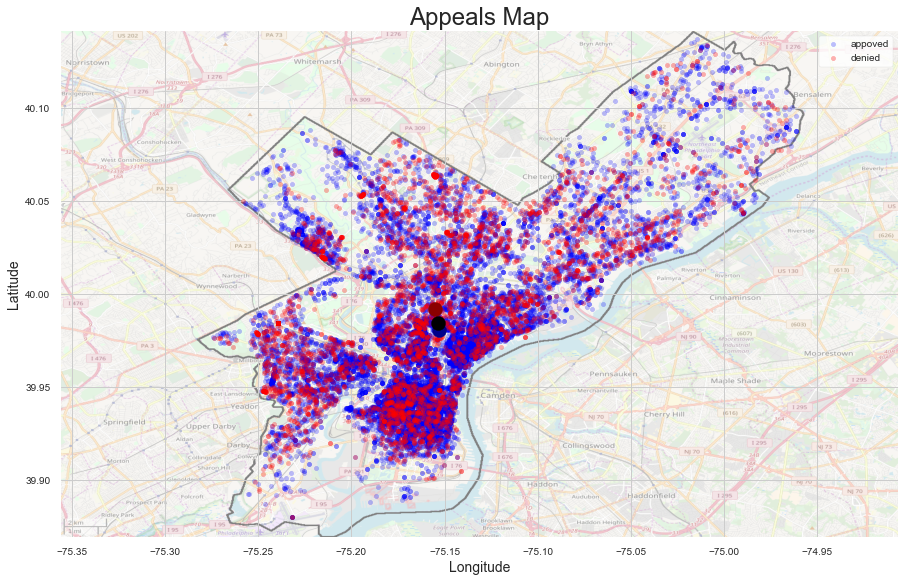

In [72]:
import numpy as np
import matplotlib.image as mpimg
philadelphia_img=mpimg.imread('images/Street_map_of_Philadelphia_and_surrounding_area.png')

plt.axes
plt.figure(figsize=(15,15))
plt.title('Appeals Map', size=24)
plt.rc('font', size=24)

plt.imshow(philadelphia_img, extent=[-75.356, -74.9066, 39.8694, 40.1414], alpha=0.5)

dfscat = df[df['newDecision'] == 'approved']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'appoved', s=20, alpha=0.25, c='blue')

dfscat = df[df['newDecision'] == 'denied']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'denied', s=20, alpha=0.3, c='red')

plt.scatter(centers.loc['denied']['lng'], centers.loc['denied']['lat'], c='darkred', s=200, alpha=1)
plt.scatter(centers.loc['approved']['lng'], centers.loc['approved']['lat'], c='darkblue', s=200, alpha=1)
plt.scatter(centers.loc['general']['lng'], centers.loc['general']['lat'], c='black', s=200, alpha=1)

plt.grid('on')
plt.legend()
plt.rc('font', size=18)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.savefig('images/appeal_map.png',bbox_inches='tight')
plt.show() 

<AxesSubplot:>

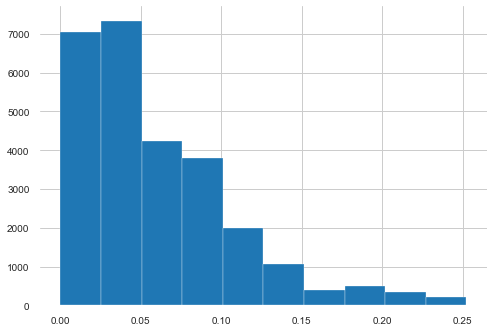

In [73]:
#Distance from CC
df['fromCC'].hist()

### myMetrics Function for model testing
[(back to the top)](#top)

In [74]:
# Create metrics function to check metrics for different models

def myMetrics(model=None, features=None, X_test=None, y_true_test=None, X_train=None, y_true_train=None):
    
    hypertablerow={}
    hypertablerow['model']=model.__class__.__name__
    #print("Model:", model.__class__.__name__)
    hypertablerow['features']=features

    X_train_temp = X_train[features]
    X_test_temp = X_test[features]  
    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.value_counts:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.value_counts:", pd.Series(y_pred_train).value_counts())

    # F1 score
    hypertablerow['f1_score_test'] = metrics.f1_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    print('f1_score_test', hypertablerow['f1_score_test'])
    hypertablerow['f1_score_train'] = metrics.f1_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    print('f1_score_train', hypertablerow['f1_score_train'])
    # Accuracy
    hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)
    print('accuracy_test', hypertablerow['accuracy_test'])
    hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train)
    print('accuracy_train', hypertablerow['accuracy_train'])
    # Precision
    hypertablerow['precision_test'] = metrics.precision_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('precision_test', hypertablerow['precision_test'])
    hypertablerow['precision_train'] = metrics.precision_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('precision_train', hypertablerow['precision_train'])
    # Recall
    hypertablerow['recall_test'] = metrics.recall_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('recall_test', hypertablerow['recall_test'])
    hypertablerow['recall_train'] = metrics.recall_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('recall_train', hypertablerow['recall_train'])

    hypertable.append(hypertablerow)
    pd.Series(hypertablerow)
    return hypertablerow

### Create "dummy" variables for systemofrecord columns

In [75]:
# Create "dummy" variables for systemofrecord columns
df = pd.concat([df, pd.get_dummies(df['systemofrecord'])], axis=1)
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng', 'decisionsv', 'provFlag',
       'newDecision', 'from_approved_center', 'from_approved_center_Sq',
       'from_denied_center', 'from_denied_center_Sq', 'from_general_center',
       'from_general_center_Sq', 'fromCC', 'fromCC_Sq', 'fromSouth',
       'fromSouth_Sq', 'fromWest', 'fromWest_Sq', 'fromNE', 'fromNE_Sq',
       'ECLIPSE', 'HANSEN'],
      dtype='object')

In [76]:
# Declare an explanatory variable, and assign some data to it 
X = df.drop(['newDecision'], axis=1)

# Declare a response variable, the decision column of the df 
y = df['newDecision'] 

In [77]:
X.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng', 'decisionsv', 'provFlag',
       'from_approved_center', 'from_approved_center_Sq', 'from_denied_center',
       'from_denied_center_Sq', 'from_general_center',
       'from_general_center_Sq', 'fromCC', 'fromCC_Sq', 'fromSouth',
       'fromSouth_Sq', 'fromWest', 'fromWest_Sq', 'fromNE', 'fromNE_Sq',
       'ECLIPSE', 'HANSEN'],
      dtype='object')

### Pre-processing and Test/Train Split
[(back to the top)](#top)

In [78]:
#UnderSampling

#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(random_state=0)
#rus.fit(X, y)

#X, y = rus.fit_resample(X, y)

In [79]:
#OverSampling

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
ros.fit(X,y)

X, y = ros.fit_resample(X, y)

In [80]:
# import the preprocessing package
from sklearn import preprocessing

# Call the train_test_split() function
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [81]:
print('X_train.shape',X_train.shape)
print('X_test.shape',X_test.shape)
print('y_train.size', y_train.size)
print('y_test.size', y_test.size)
print('y_train.value_counts',y_train.value_counts())
print('y_train.describe', y_test.value_counts())

X_train.shape (37543, 55)
X_test.shape (12515, 55)
y_train.size 37543
y_test.size 12515
y_train.value_counts denied      12556
other       12504
approved    12483
Name: newDecision, dtype: int64
y_train.describe approved    4203
other       4182
denied      4130
Name: newDecision, dtype: int64


### Testing LinearSVC model

In [82]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#model = GaussianNB()
#model = KNeighborsClassifier(n_neighbors=10)
model = svm.LinearSVC() # Linear Kernel
#model = svm.SVC(kernel='poly') # Linear Kernel
features=['ECLIPSE']

y_true_train = y_train
y_true_test = y_test
print('y_true_test.value_counts()', y_true_test.value_counts())


hypertablerow={}
hypertablerow['model']=model.__class__.__name__
print("Model:", model.__class__.__name__)
hypertablerow['features']=features

X_train_temp = X_train[features]
X_test_temp = X_test[features]  
print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['ECLIPSE', 'fromCC']

X_train_temp = X_train[features]
X_test_temp = X_test[features]  

print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['ECLIPSE','fromCC', 'censustract']

X_train_temp = X_train[features]
X_test_temp = X_test[features]  

print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_true_test.value_counts() approved    4203
other       4182
denied      4130
Name: newDecision, dtype: int64
Model: LinearSVC
X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.describe: denied      12330
approved      185
dtype: int64
y_pred_train.describe: denied      36959
approved      584
dtype: int64
Test Accuracy 0.33599680383539754
Train Accuracy 0.3411288389313587
X_train_temp.columns: Index(['ECLIPSE', 'fromCC'], dtype='object')
y_pred_test.describe: approved    6908
denied      5607
dtype: int64
y_pred_train.describe: approved    20580
denied      16963
dtype: int64
Test Accuracy 0.4066320415501398
Train Accuracy 0.40071384812082145
X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract'], dtype='object')
y_pred_test.describe: denied      10162
approved     2353
dtype: int64
y_pred_train.describe: denied      30586
approved     6957
dtype: int64
Test Accuracy 0.36292449061126647
Train Accuracy 0.36518125882321606


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Testing KNeighborsClassifier model

In [83]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier(n_neighbors=10)
#model = svm.LinearSVC() # Linear Kernel
model = svm.SVC(kernel='poly', degree=2) # Poy Kernel - takes VERY LONG time
features=['ECLIPSE']

y_true_train = y_train
y_true_test = y_test
print('y_true_test.value_counts()', y_true_test.value_counts())


hypertablerow={}
hypertablerow['model']=model.__class__.__name__
print("Model:", model.__class__.__name__)
hypertablerow['features']=features

X_train_temp = X_train[features]
X_test_temp = X_test[features]  
print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['ECLIPSE', 'fromCC']

X_train_temp = X_train[features]
X_test_temp = X_test[features]  

print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['ECLIPSE','fromCC', 'censustract']

X_train_temp = X_train[features]
X_test_temp = X_test[features]  

print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_true_test.value_counts() approved    4203
other       4182
denied      4130
Name: newDecision, dtype: int64
Model: SVC
X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.describe: denied      12330
approved      185
dtype: int64
y_pred_train.describe: denied      36959
approved      584
dtype: int64
Test Accuracy 0.33599680383539754
Train Accuracy 0.3411288389313587
X_train_temp.columns: Index(['ECLIPSE', 'fromCC'], dtype='object')
y_pred_test.describe: approved    11274
denied       1238
other           3
dtype: int64
y_pred_train.describe: approved    33818
denied       3715
other          10
dtype: int64
Test Accuracy 0.3421494206951658
Train Accuracy 0.3353488000426178
X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract'], dtype='object')
y_pred_test.describe: denied      12415
approved      100
dtype: int64
y_pred_train.describe: denied      37201
approved      342
dtype: int64
Test Accuracy 0.32952457051538153
Train Accuracy 0.33572170577737526


### Confusion Matrix

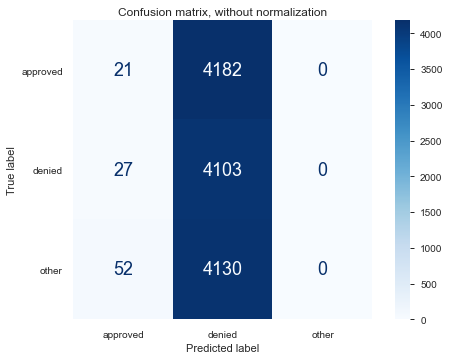

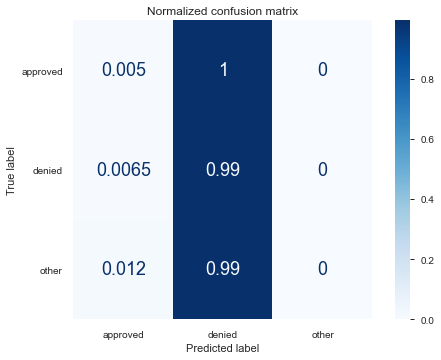

In [84]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test_temp, y_true_test,
                                 display_labels=y_true_test.sort_values().unique(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

#    print(title)
#    print(disp.confusion_matrix)

plt.show()


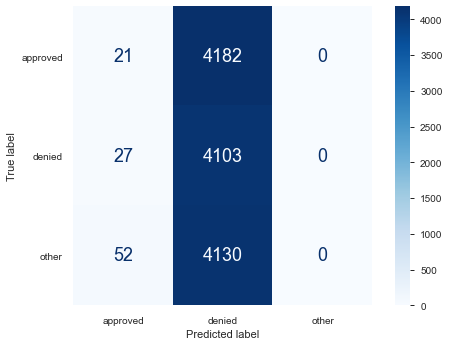

In [85]:
plot_confusion_matrix(model, X_test_temp[features], y_true_test,
                                 display_labels=y_true_test.unique(),
                                 cmap=plt.cm.Blues)

### LogisticRegression
[(back to the top)](#top)

In [86]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
features=['ECLIPSE']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.value_counts: denied      12330
approved      185
dtype: int64
y_pred_train.value_counts: denied      36959
approved      584
dtype: int64
f1_score_test 0.18002105817106015
f1_score_train 0.18552988531338074
accuracy_test 0.33599680383539754
accuracy_train 0.3411288389313587


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
features=['ECLIPSE', 'fromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC'], dtype='object')
y_pred_test.value_counts: approved    6789
denied      5388
other        338
dtype: int64
y_pred_train.value_counts: approved    20229
denied      16372
other         942
dtype: int64
f1_score_test 0.33791243973141555
f1_score_train 0.33397734028773596
accuracy_test 0.40567319216939673
accuracy_train 0.4011932983512239


In [88]:
features=['ECLIPSE', 'fromCC', 'censustract']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract'], dtype='object')
y_pred_test.value_counts: other    12515
dtype: int64
y_pred_train.value_counts: other    37543
dtype: int64
f1_score_test 0.16738970790301083
f1_score_train 0.16642589564615962
accuracy_test 0.33415900918897323
accuracy_train 0.3330580933862504


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center'], dtype='object')
y_pred_test.value_counts: denied      8983
other       3315
approved     217
dtype: int64
y_pred_train.value_counts: denied      26796
other       10063
approved      684
dtype: int64
f1_score_test 0.24810369820432993
f1_score_train 0.2522801489293439
accuracy_test 0.3166600079904115
accuracy_train 0.3216578323522361


In [90]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE'],
      dtype='object')
y_pred_test.value_counts: denied      8983
other       3315
approved     217
dtype: int64
y_pred_train.value_counts: denied      26796
other       10063
approved      684
dtype: int64
f1_score_test 0.24810369820432993
f1_score_train 0.2522801489293439
accuracy_test 0.3166600079904115
accuracy_train 0.3216578323522361


In [91]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'from_approved_center', 'from_denied_center']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'from_approved_center', 'from_denied_center'],
      dtype='object')
y_pred_test.value_counts: denied      8983
other       3315
approved     217
dtype: int64
y_pred_train.value_counts: denied      26796
other       10063
approved      684
dtype: int64
f1_score_test 0.24810369820432993
f1_score_train 0.2522801489293439
accuracy_test 0.3166600079904115
accuracy_train 0.3216578323522361


In [92]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
hypertablerow = myMetrics(model=model,features=features,
                          X_train=X_train,y_true_train=y_train,
                          X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq',
       'fromNE_Sq'],
      dtype='object')
y_pred_test.value_counts: denied      8983
other       3315
approved     217
dtype: int64
y_pred_train.value_counts: denied      26796
other       10063
approved      684
dtype: int64
f1_score_test 0.24810369820432993
f1_score_train 0.2522801489293439
accuracy_test 0.3166600079904115
accuracy_train 0.3216578323522361


In [93]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center']
hypertablerow = myMetrics(model=model,features=features,
                          X_train=X_train,y_true_train=y_train,
                          X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq',
       'fromNE_Sq', 'from_approved_center', 'from_denied_center'],
      dtype='object')
y_pred_test.value_counts: denied      8983
other       3315
approved     217
dtype: int64
y_pred_train.value_counts: denied      26796
other       10063
approved      684
dtype: int64
f1_score_test 0.24810369820432993
f1_score_train 0.2522801489293439
accuracy_test 0.3166600079904115
accuracy_train 0.3216578323522361


In [94]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center',
         'from_approved_center_Sq', 'from_denied_center_Sq']
hypertablerow = myMetrics(model=model,features=features,
                          X_train=X_train,y_true_train=y_train,
                          X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq',
       'fromNE_Sq', 'from_approved_center', 'from_denied_center',
       'from_approved_center_Sq', 'from_denied_center_Sq'],
      dtype='object')
y_pred_test.value_counts: denied      8992
other       3334
approved     189
dtype: int64
y_pred_train.value_counts: denied      26824
other       10115
approved      604
dtype: int64
f1_score_test 0.2478453430319045
f1_score_train 0.2522181800190494
accuracy_test 0.31713943268078304
accuracy_train 0.32237700769783983


### KNeighborsClassifier Model

In [95]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
features=['ECLIPSE']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.value_counts: approved    12515
dtype: int64
y_pred_train.value_counts: approved    37543
dtype: int64
f1_score_test 0.1688626501410414
f1_score_train 0.16593698102227233
accuracy_test 0.3358369956052737
accuracy_train 0.33249873478411424


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
features=['ECLIPSE', 'fromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC'], dtype='object')
y_pred_test.value_counts: denied      4941
other       3792
approved    3782
dtype: int64
y_pred_train.value_counts: denied      14916
approved    11327
other       11300
dtype: int64
f1_score_test 0.5233580772666808
f1_score_train 0.6261999546053583
accuracy_test 0.5262485017978425
accuracy_train 0.6285592520576406


In [97]:
features=['ECLIPSE', 'fromCC', 'censustract']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract'], dtype='object')
y_pred_test.value_counts: denied      4877
approved    3862
other       3776
dtype: int64
y_pred_train.value_counts: denied      14647
approved    11547
other       11349
dtype: int64
f1_score_test 0.5598006649773979
f1_score_train 0.6543560481713093
accuracy_test 0.5621254494606472
accuracy_train 0.6562341848014277


In [98]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center'], dtype='object')
y_pred_test.value_counts: denied      4871
approved    3886
other       3758
dtype: int64
y_pred_train.value_counts: denied      14652
approved    11523
other       11368
dtype: int64
f1_score_test 0.5597590873917171
f1_score_train 0.657428299761817
accuracy_test 0.5619656412305234
accuracy_train 0.65927070292731


In [99]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE'],
      dtype='object')
y_pred_test.value_counts: denied      4880
other       3833
approved    3802
dtype: int64
y_pred_train.value_counts: denied      14704
other       11467
approved    11372
dtype: int64
f1_score_test 0.5607920237235886
f1_score_train 0.6596236635444775
accuracy_test 0.5628445864962045
accuracy_train 0.6614548650880324


In [100]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'from_approved_center', 'from_denied_center']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'from_approved_center', 'from_denied_center'],
      dtype='object')
y_pred_test.value_counts: denied      4856
approved    3835
other       3824
dtype: int64
y_pred_train.value_counts: denied      14569
other       11545
approved    11429
dtype: int64
f1_score_test 0.5610431772511488
f1_score_train 0.6596610925545289
accuracy_test 0.5631642029564523
accuracy_train 0.6614282289641211


In [101]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
hypertablerow = myMetrics(model=model,features=features,
                          X_train=X_train,y_true_train=y_train,
                          X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq',
       'fromNE_Sq'],
      dtype='object')
y_pred_test.value_counts: denied      4865
other       3838
approved    3812
dtype: int64
y_pred_train.value_counts: denied      14680
other       11484
approved    11379
dtype: int64
f1_score_test 0.5606720582625739
f1_score_train 0.6587991412513186
accuracy_test 0.5626847782660807
accuracy_train 0.6606025091228724


In [102]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center']
hypertablerow = myMetrics(model=model,features=features,
                          X_train=X_train,y_true_train=y_train,
                          X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq',
       'fromNE_Sq', 'from_approved_center', 'from_denied_center'],
      dtype='object')
y_pred_test.value_counts: denied      4854
approved    3849
other       3812
dtype: int64
y_pred_train.value_counts: denied      14568
other       11551
approved    11424
dtype: int64
f1_score_test 0.5607460878579356
f1_score_train 0.6598051592301376
accuracy_test 0.5628445864962045
accuracy_train 0.6615614095836774


In [103]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center',
         'from_approved_center_Sq', 'from_denied_center_Sq']
hypertablerow = myMetrics(model=model,features=features,
                          X_train=X_train,y_true_train=y_train,
                          X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq',
       'fromNE_Sq', 'from_approved_center', 'from_denied_center',
       'from_approved_center_Sq', 'from_denied_center_Sq'],
      dtype='object')
y_pred_test.value_counts: denied      4804
approved    3906
other       3805
dtype: int64
y_pred_train.value_counts: denied      14589
other       11528
approved    11426
dtype: int64
f1_score_test 0.5586690809045777
f1_score_train 0.6496555287910389
accuracy_test 0.5606871753895326
accuracy_train 0.6514663186213142


### Gaussian Naive Bayes Model

In [104]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
features=['ECLIPSE']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.value_counts: denied      12330
approved      185
dtype: int64
y_pred_train.value_counts: denied      36959
approved      584
dtype: int64
f1_score_test 0.18002105817106015
f1_score_train 0.18552988531338074
accuracy_test 0.33599680383539754
accuracy_train 0.3411288389313587


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
features=['ECLIPSE','fromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC'], dtype='object')
y_pred_test.value_counts: denied      12330
approved      185
dtype: int64
y_pred_train.value_counts: denied      36959
approved      584
dtype: int64
f1_score_test 0.18002105817106015
f1_score_train 0.18552988531338074
accuracy_test 0.33599680383539754
accuracy_train 0.3411288389313587


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
features=['ECLIPSE','fromCC', 'censustract']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract'], dtype='object')
y_pred_test.value_counts: denied      12232
approved      283
dtype: int64
y_pred_train.value_counts: denied      36619
approved      924
dtype: int64
f1_score_test 0.18280477007374848
f1_score_train 0.1915951502440493
accuracy_test 0.33567718737514984
accuracy_train 0.3424073728790986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
features=['ECLIPSE','fromCC', 'censustract', 'from_general_center']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center'], dtype='object')
y_pred_test.value_counts: denied      12232
approved      283
dtype: int64
y_pred_train.value_counts: denied      36619
approved      924
dtype: int64
f1_score_test 0.18280477007374848
f1_score_train 0.1915951502440493
accuracy_test 0.33567718737514984
accuracy_train 0.3424073728790986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
features=['ECLIPSE','fromCC', 'from_general_center']
hypertablerow = myMetrics(model=model,
                          features=features,
                          X_train=X_train,
                          y_true_train=y_train,
                          X_test=X_test,
                          y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'from_general_center'], dtype='object')
y_pred_test.value_counts: denied      12330
approved      185
dtype: int64
y_pred_train.value_counts: denied      36959
approved      584
dtype: int64
f1_score_test 0.18002105817106015
f1_score_train 0.18552988531338074
accuracy_test 0.33599680383539754
accuracy_train 0.3411288389313587


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
hypertablerow = myMetrics(model=model,
                          features=features,
                          X_train=X_train,
                          y_true_train=y_train,
                          X_test=X_test,
                          y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE'],
      dtype='object')
y_pred_test.value_counts: denied      12232
approved      259
other          24
dtype: int64
y_pred_train.value_counts: denied      36619
approved      845
other          79
dtype: int64
f1_score_test 0.1829783005995267
f1_score_train 0.19177934310764969
accuracy_test 0.33567718737514984
accuracy_train 0.3423807367551874


In [110]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
hypertablerow = myMetrics(model=model,features=features,
                          X_train=X_train,y_true_train=y_train,
                          X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq',
       'fromNE_Sq'],
      dtype='object')
y_pred_test.value_counts: denied      12232
approved      257
other          26
dtype: int64
y_pred_train.value_counts: denied      36619
approved      841
other          83
dtype: int64
f1_score_test 0.1833028904106243
f1_score_train 0.1919969595231937
accuracy_test 0.3358369956052737
accuracy_train 0.3424872812508324


### Random Forrest Classifier Model

In [111]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification
model = RandomForestClassifier(max_depth= 5, random_state= 1234)
features=['ECLIPSE']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.value_counts: denied      12330
approved      185
dtype: int64
y_pred_train.value_counts: denied      36959
approved      584
dtype: int64
f1_score_test 0.18002105817106015
f1_score_train 0.18552988531338074
accuracy_test 0.33599680383539754
accuracy_train 0.3411288389313587


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
features=['ECLIPSE','fromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC'], dtype='object')
y_pred_test.value_counts: approved    5199
denied      4532
other       2784
dtype: int64
y_pred_train.value_counts: approved    15614
denied      13651
other        8278
dtype: int64
f1_score_test 0.4110598520445063
f1_score_train 0.41706094568756363
accuracy_test 0.4202157411106672
accuracy_train 0.42623125482779745


In [113]:
features=['ECLIPSE','fromCC', 'censustract']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract'], dtype='object')
y_pred_test.value_counts: approved    5732
denied      5404
other       1379
dtype: int64
y_pred_train.value_counts: approved    17228
denied      16295
other        4020
dtype: int64
f1_score_test 0.3920347268017438
f1_score_train 0.3966357249614745
accuracy_test 0.4245305633240112
accuracy_train 0.42932104520150227


In [114]:
features=['ECLIPSE','fromCC', 'censustract', 'from_general_center']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center'], dtype='object')
y_pred_test.value_counts: approved    5685
denied      5224
other       1606
dtype: int64
y_pred_train.value_counts: approved    17013
denied      15704
other        4826
dtype: int64
f1_score_test 0.41846843786124754
f1_score_train 0.4275699273238098
accuracy_test 0.4434678385936876
accuracy_train 0.45174866153477344


y_true_test.value_counts() approved    4203
other       4182
denied      4130
Name: newDecision, dtype: int64
Model: RandomForestClassifier
X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center'], dtype='object')
y_pred_test.describe: approved    5685
denied      5224
other       1606
dtype: int64
y_pred_train.describe: approved    17013
denied      15704
other        4826
dtype: int64
Test Accuracy 0.4434678385936876
Train Accuracy 0.45174866153477344
X_train_temp.columns: Index(['ECLIPSE', 'fromCC'], dtype='object')
y_pred_test.describe: approved    5199
denied      4532
other       2784
dtype: int64
y_pred_train.describe: approved    15614
denied      13651
other        8278
dtype: int64
Test Accuracy 0.4202157411106672
Train Accuracy 0.42623125482779745
X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract'], dtype='object')
y_pred_test.describe: approved    5732
denied      5404
other       1379
dtype: int64
y_pred_train.describe: approved 

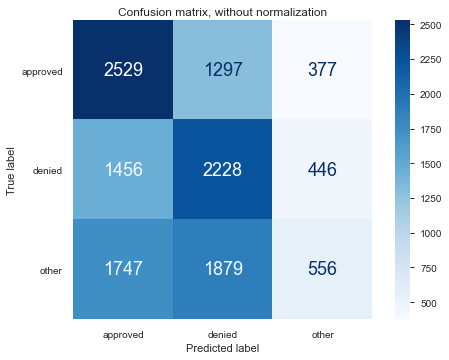

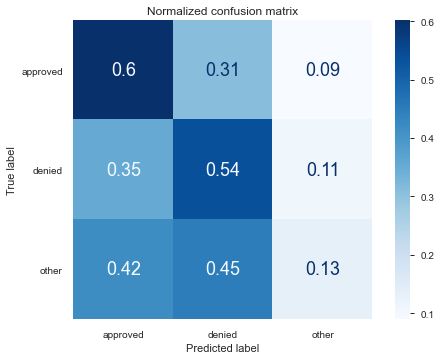

In [115]:
y_true_train = y_train
y_true_test = y_test
print('y_true_test.value_counts()', y_true_test.value_counts())


print("Model:", model.__class__.__name__)

X_train_temp = X_train[features]
X_test_temp = X_test[features]  
print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['ECLIPSE', 'fromCC']

X_train_temp = X_train[features]
X_test_temp = X_test[features]  

print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['ECLIPSE','fromCC', 'censustract']

X_train_temp = X_train[features]
X_test_temp = X_test[features]  

print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test_temp, y_true_test,
                                 display_labels=y_true_test.sort_values().unique(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

#    print(title)
#    print(disp.confusion_matrix)

plt.show()


### Decision Tree Classifier

In [116]:
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion="gini", max_depth = 5, random_state = 1234)

features=['ECLIPSE']
hypertablerow = myMetrics(model=model,
                          features=features,
                          X_train=X_train,
                          y_true_train=y_train,
                          X_test=X_test,
                          y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.value_counts: denied      12330
approved      185
dtype: int64
y_pred_train.value_counts: denied      36959
approved      584
dtype: int64
f1_score_test 0.18002105817106015
f1_score_train 0.18552988531338074
accuracy_test 0.33599680383539754
accuracy_train 0.3411288389313587


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
features=['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
hypertablerow = myMetrics(model=model,features=features,
                          X_train=X_train,y_true_train=y_train,
                          X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'censustract', 'from_general_center', 'fromSouth',
       'fromWest', 'fromNE', 'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq',
       'fromNE_Sq'],
      dtype='object')
y_pred_test.value_counts: denied      6345
approved    5051
other       1119
dtype: int64
y_pred_train.value_counts: denied      18977
approved    15036
other        3530
dtype: int64
f1_score_test 0.3839290913308209
f1_score_train 0.39024102058360993
accuracy_test 0.4238913304035158
accuracy_train 0.42809578350158484


## Final Hypertable

In [118]:
pd.DataFrame(hypertable).to_csv('hypertable.csv')
dfhypertable=pd.DataFrame(hypertable).sort_values('precision_test')
pd.set_option('display.max_colwidth', -1)
dfhypertable.round(3).sort_values('f1_score_test',  ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,model,features,f1_score_test,f1_score_train,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train
13,KNeighborsClassifier,"[ECLIPSE, fromCC, censustract, from_general_center, fromSouth, fromWest, fromNE]",0.561,0.660,0.563,0.661,0.563,0.662,0.563,0.661
14,KNeighborsClassifier,"[ECLIPSE, fromCC, censustract, from_general_center, fromSouth, fromWest, fromNE, from_approved_center, from_denied_center]",0.561,0.660,0.563,0.661,0.563,0.662,0.563,0.661
16,KNeighborsClassifier,"[ECLIPSE, fromCC, censustract, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center]",0.561,0.660,0.563,0.662,0.563,0.662,0.563,0.662
15,KNeighborsClassifier,"[ECLIPSE, fromCC, censustract, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.561,0.659,0.563,0.661,0.563,0.662,0.563,0.661
12,KNeighborsClassifier,"[ECLIPSE, fromCC, censustract, from_general_center]",0.560,0.657,0.562,0.659,0.562,0.660,0.562,0.659
11,KNeighborsClassifier,"[ECLIPSE, fromCC, censustract]",0.560,0.654,0.562,0.656,0.562,0.657,0.562,0.656
17,KNeighborsClassifier,"[ECLIPSE, fromCC, censustract, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center, from_approved_center_Sq, from_denied_center_Sq]",0.559,0.650,0.561,0.651,0.560,0.652,0.561,0.651
10,KNeighborsClassifier,"[ECLIPSE, fromCC]",0.523,0.626,0.526,0.629,0.525,0.629,0.526,0.629
28,RandomForestClassifier,"[ECLIPSE, fromCC, censustract, from_general_center]",0.418,0.428,0.443,0.452,0.449,0.460,0.443,0.452
26,RandomForestClassifier,"[ECLIPSE, fromCC]",0.411,0.417,0.420,0.426,0.415,0.422,0.420,0.426
